<a href="https://colab.research.google.com/github/VindhyaSRajan/Master-s-Thesis/blob/master/Exploratory_Data_Analysis_Amazon.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
from google.colab import drive
drive.mount('/content/drive')

##Data Exploration

In [0]:
!pip install gensim
!pip install bs4
!pip install pyLDAvis
!pip install warnings

In [1]:
import pandas as pd
pd.set_option('display.max_colwidth', -1)  # to view entire text in any column
import numpy as np
import random
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import re
import string
import gzip
from pprint import pprint

from bs4 import BeautifulSoup
import nltk
from nltk import FreqDist
nltk.download('stopwords') 
from nltk.corpus import stopwords
# from nltk.stem.wordnet import WordNetLemmatizer  # alternative lemmatizer
# lemma = WordNetLemmatizer()

import spacy
import gensim
from gensim import corpora
from gensim.models import CoherenceModel

import pyLDAvis
import pyLDAvis.gensim   # for visualizing found topics

import os


import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)  # suppressing deprecation warnings when running gensim LDA

#from specialmaps import CONTRACTION_MAP
#from collections import defaultdict

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [0]:
import pandas as pd
import gzip
import json

def parse(path):
  g = gzip.open(path, 'rb')
  for l in g:
    yield json.loads(l)

def getDF(path):
  i = 0
  df = {}
  for d in parse(path):
    df[i] = d
    i += 1
  return pd.DataFrame.from_dict(df, orient='index')

In [3]:
df = pd.read_csv('/content/drive/My Drive/Amazon_data/reviews_Patio_Lawn_And_Garden.csv', nrows  = 100000, error_bad_lines = False)
#meta_df = getDF('/content/drive/My Drive/Amazon_data/meta_Patio_Lawn_and_Garden.json.gz')
print('Shape of the actual data is ',df.shape)
#print('Shape of the meta-data is ', meta_df.shape)

Shape of the actual data is  (100000, 9)


In [4]:
df = df[['asin','reviewText','overall','summary']]
df.sample(5)

,asin,reviewText,overall,summary
60205,B0000AV0T8,"I bought this product for my parents and they love it! My mom hates to pop the cork on champagne and now its so easy for her. I will def. purchase this product again for gifts in the future. I liked the box it came in too, very pretty.",5.0,great gift idea
81526,B00022OK2A,"It's back to basics with this little jewel. I love the convenience and simplicity of this grill. It makes quick work of most meats, i.e. steaks , burgers & brats. Chicken takes a little more care and attention to avoid burning or cooking too fast. It takes a time or two to get the right amount of charcoals and venting just right, but once you do, it's easy to prepare a meal in a jiffy. Clean up is a snap too, but remember to wipe it down with a little veggie oil before storing it away.",5.0,Best Little Grill Ever...
5211,B00002NC1Y,Bought as a gift for Christmas last year and it cleaned the BBQ Grill well. It did what its suppose to do.,5.0,works well
80936,B00021FLQK,Nice cover that's fits my Sears 5 burner grill.,5.0,Five Stars
65293,B0000DBIKK,"I wanted a set that was high quality, had a knife, and wasn't outrageously priced. I didn't want a 12, 18, or more piece set as I didn't need corn cob holders, skewers, grill brush, etc. This set meets all of my requirements. The tools are 18 1/2"" long. This prevents you from having your hand over hot parts of the grill. The metal thickness is 3/32"". This is much thicker than the thinner guage of lower priced sets. The handles are thick, beaufifully rounded, and very comfortable to hold. There are no rough or sharp edges on the stainless steel. The same quality by other makers easily approaches $100. Check the pieces of any other set [except for Weber, which does not offer a knife] and compare. You'll find they are thin stainless steel, have less than comfortable handles, have sharp or rough edges on the stainless steel, and may be much shorter. To top all of the qreat qualities of this set, it's backed by a lifetime warranty [excluding the brush on the baster.]",5.0,"Top quality, heavy guage stainless BBQ tools"


In [0]:
# function to plot most frequent terms. This is used to gauge the quality of text processing
def freq_words(x, terms = 30):
  all_words = ' '.join([text for text in x])
  all_words = all_words.split()

  fdist = FreqDist(all_words)
  words_df = pd.DataFrame({'word':list(fdist.keys()), 'count':list(fdist.values())})

  # selecting top n most frequent words
  d = words_df.nlargest(columns="count", n = terms) 
  plt.figure(figsize=(20,5))
  ax = sns.barplot(data=d, x= "word", y = "count")
  ax.set(ylabel = 'Count')
  plt.show()

In [6]:
df = df.dropna(subset = ['reviewText'])
df.shape[0] #shape should come around 99941

99941

Top 10 most reviewed:
          asin  reviewCnt
0  B000071NUS  2339     
1  B00004R9VV  2083     
2  B00004SD7B  1706     
3  B00004RA3E  944      
4  B0001Q2EMU  876      
5  B00005OQMG  800      
6  B00025H2PY  793      
7  B00022OK2A  657      
8  B00004DTNH  640      
9  B00005AKZI  637       

count    4409.000000
mean     22.667498  
std      81.517822  
min      1.000000   
25%      2.000000   
50%      4.000000   
75%      13.000000  
max      2339.000000
Name: reviewCnt, dtype: float64


(-1, 100)

<Figure size 576x720 with 0 Axes>

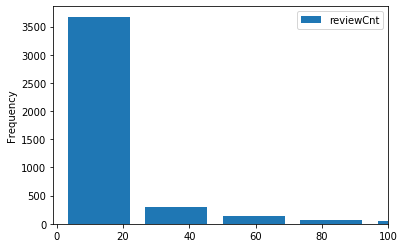

In [10]:
#Amazon Review Data
# number of asins, number of associated reviews for each asin
review_cnts = df.groupby('asin').agg({'reviewText':'count'}).sort_values(by = 'reviewText', ascending = False)
review_cnts = review_cnts.reset_index()
review_cnts = review_cnts.rename({'reviewText':'reviewCnt'}, axis = 'columns')
print('Top 10 most reviewed:\n', review_cnts.head(10),'\n')
print(review_cnts.reviewCnt.describe())
plt.figure(figsize=(8,10))

# a few products are much more highly reviewed than the rest, zoom in to x < 200
review_cnts.plot.hist(by='reviewCnt', bins = 100, rwidth = 0.8)  
plt.xlim([-1,100])   # enmt: log y axis

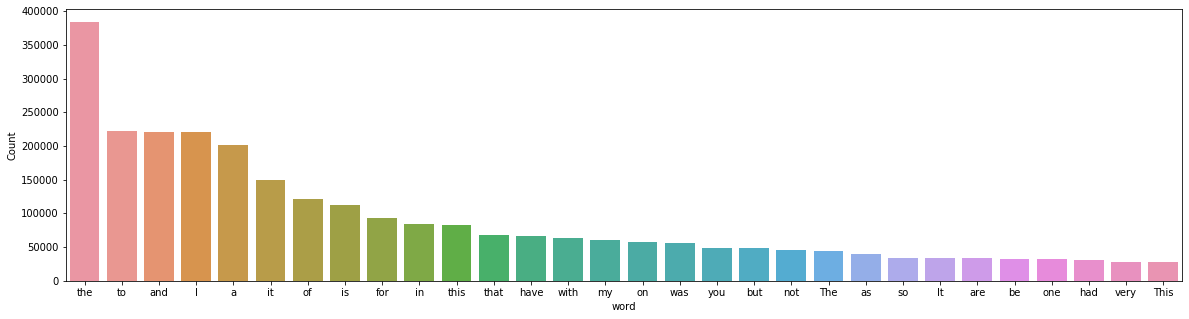

In [11]:
freq_words(list(df['reviewText']))

In [0]:
# functions for text cleaning and pre-processing

def chk_has_html(rev_df,print_all=True):
    # check for review text that has tags such as &#34;
    # rev_df: e.g. df['reviewText']
    html_num = defaultdict(int)
    review_w_html = []
    for idx, text in enumerate(rev_df):
        strange_text = re.findall(r'&#\d+;',text)
        if len(strange_text) > 1:
            for t in strange_text:
                html_num[t] += 1
            review_w_html.append(text)
    
    if print_all == True:
        print(sorted(html_num.items(), key = lambda kv:(kv[1], kv[0]), reverse=True))     
    return html_num

def chk_html_num(rev_df,tag):
    # prints reviews that contain the special HTML numbers specified by tag
    # tag: HTML numbers with pattern r'&#\d+;'
    for idx, text in enumerate(rev_df):
        if tag in text:
            print(idx, text, '\n')

def convert_html(rev): 
    # replace the html tags by the corresponding symbol using HTML_MAP
    html_entity = re.findall(r'&#\d+;',rev)
    rev_new = rev
    if len(html_entity) > 0:
        for t in html_entity:
            rev_new = rev_new.replace(t,HTML_MAP[t])
    return rev_new

def remove_html_tags(text):
    return BeautifulSoup(text, "html.parser").get_text()

# def expand_contractions(text, contraction_mapping=CONTRACTION_MAP):    
#     # expand contractions. I'm -> I am. Aren't -> are not
#     # This is a simple version, see more elaborate version that considers word sense: https://pypi.org/project/pycontractions/
#     contractions_pattern = re.compile('({})'.format('|'.join(contraction_mapping.keys())), 
#                                       flags=re.IGNORECASE|re.DOTALL)
    
#     def expand_match(contraction):
#         match = contraction.group(0)
#         first_char = match[0]
#         expanded_contraction = contraction_mapping.get(match)\
#                                 if contraction_mapping.get(match)\
#                                 else contraction_mapping.get(match.lower())                       
#         expanded_contraction = first_char+expanded_contraction[1:]
#         return expanded_contraction

#     expanded_text = contractions_pattern.sub(expand_match, text)
#     expanded_text = re.sub("'", "", expanded_text)
#     return expanded_text

punc_char = set(string.punctuation)

def remove_punctuation(rev):
    # remove punctuation from the input string rev
    return ''.join([ch for ch in rev if ch not in punc_char])

stop_words = stopwords.words('english')
stop_words.extend(['would','dont','cant','should'])  

def remove_stopwords(rev):
    # rev is a review text, one string
    rev_new = " ".join([i for i in rev.split() if i not in stop_words])
    return rev_new

nlp = spacy.load('en', disable=['parser', 'ner'])

def lemmatization(rev): 
    # lemmatize input string rev, i.e. reduce all forms of a word to the lemma
    doc = nlp(" ".join(rev.split()))
    return " ".join([token.lemma_ for token in doc])

def lemmatization_tag(rev, tags = ['NOUN', 'ADJ']): # filter noun and adjective
    doc = nlp(" ".join(rev.split()))
    return " ".join([token.lemma_ for token in doc if token.pos_ in tags])

def remove_num(s):
    # s is a string, e.g. an entire review text
    return ''.join([i for i in s if not i.isdigit()])

In [8]:
# use beautiful soup to remove html entities

df.loc[:,'review_no_html'] = df['reviewText'].apply(remove_html_tags)
df.loc[:,'review_no_html'] = df['review_no_html'].apply(remove_html_tags)

/usr/local/lib/python3.6/dist-packages/bs4/__init__.py:273: UserWarning: "b'.'" looks like a filename, not markup. You should probably open this file and pass the filehandle into Beautiful Soup.
  ' Beautiful Soup.' % markup)


In [14]:
df['review_no_html'].sample(5)

45369    I have used mine four times in the last two weeks. In fact, I needed it a day earlier than the first snow here in upper NH. Despite the fact that most of the externals are plastic, it works perfectly, on light snow and wet snow. I have a driveway that is about 50' x 28', and I get it done in ten minutes. It has plenty of power. The only issue I have is that my driveway is crushed gravel and stone. And the stones - when I manage to go too low - are thrown against the side of my neighbor's house. :)I also bought the 100' Coleman cable. I would highly recommend this pair of products.                                                                                                                                                                                                                                                                                                                                                                          
92086    Since I had purchased a wrought 

In [15]:
# contraction expansion tests

#df.loc[:,'review_no_contraction'] = df['review_no_html'].apply(expand_contractions)
print(df['review_no_html'].sample(n=5, random_state = 0))
print("\n")
#print(df['review_no_contraction'].sample(n=5, random_state = 0))

26178    These shears are ergonomic and work great.  Makes pruninga much easier task.  You won't regret the purchase.Its been one season and they seem to have kept fairly sharp.                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                       

In [0]:
df.loc[:,'review_no_punc'] = [remove_punctuation(r) for r in df['review_no_html']]
#df[:'review_no_punc']

In [0]:
df.shape()

In [0]:
df.loc[:,'review_no_stopwords'] = [remove_stopwords(r.lower()) for r in df['review_no_html']]

In [10]:
print(df['reviewText'].sample(n=5, random_state = 0),'\n')
#print(df['review_no_punc'].sample(n=5, random_state = 0),'\n')
print(df['review_no_stopwords'].sample(n=5, random_state = 0),'\n')

26178    These shears are ergonomic and work great.  Makes pruninga much easier task.  You won't regret the purchase.Its been one season and they seem to have kept fairly sharp.                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                       

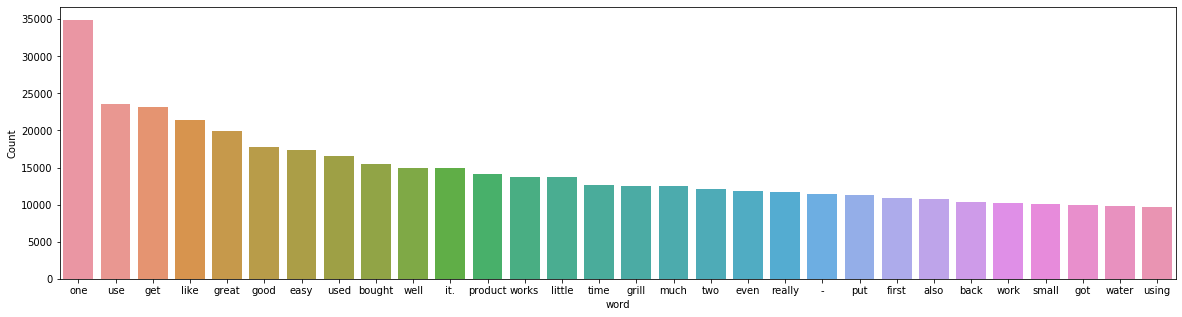

In [11]:
freq_words(df['review_no_stopwords'])

In [0]:
# lemmatize, this is a relatively slow preprocessing step 
df.loc[:,'review_lemmatized'] = df['review_no_stopwords'].apply(lemmatization)

In [0]:
# run remove stop words again because the lemmatization process generates more stop words
df.loc[:,'review_lemmatized'] = df['review_lemmatized'].apply(remove_stopwords)

In [0]:
# remove numbers
df.loc[:, 'review_lemmatized'] = df['review_lemmatized'].apply(remove_num)

In [0]:
print(df['reviewText'].sample(n=3, random_state = 0),'\n')
print(df['review_no_stopwords'].sample(n=3, random_state = 0),'\n')
print(df['review_lemmatized'].sample(n=3, random_state = 0),'\n')

In [0]:
# PorterStemmer deals with cases like TVs, but produce incomplete workds like instal
from nltk.stem import PorterStemmer
porter = PorterStemmer()
print(porter.stem('installation'))
print(porter.stem('tvs'))

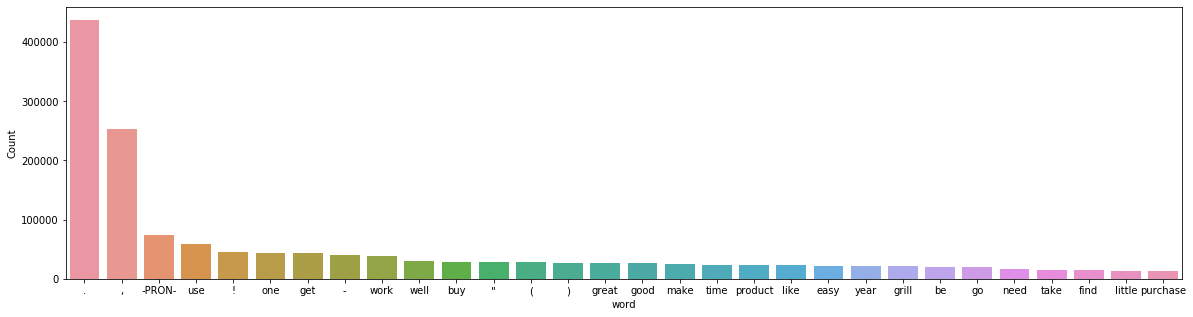

In [15]:
freq_words(df['review_lemmatized'])

In [14]:
df.columns

Index(['asin', 'reviewText', 'overall', 'summary', 'review_no_html',
       'review_no_stopwords', 'review_lemmatized'],
      dtype='object')

In [0]:
# save processed review df for LDA modeling
# remove html in 'title'

df[['asin', 'overall', 'reviewText', 'review_no_html', 'review_lemmatized']].to_csv('lawn_processed.csv')

In [17]:
# useful attributes & methods: dictionary.token2id to get mapping, dictionary.num_docs 
df = pd.read_csv("/content/drive/My Drive/Amazon_data/processed.csv", index_col= 0)
reviews = df['review_lemmatized'].copy()
reviews = reviews.apply(lambda x: x.split())

# Dictionary expects a list of list (of tokens)
dictionary = corpora.Dictionary(reviews)
dictionary.filter_extremes(no_below=3)  # remove terms that appear in < 3 documents, memory use estimate: 8 bytes * num_terms * num_topics * 3

# number of terms
nd = dictionary.num_docs
nt = len(dictionary.keys())
print("number of documents", nd)
print("number of terms", nt)

# check some ids and tokens in the dictionary
for i in random.sample(range(nt),10):
    print(i, dictionary[i])

number of documents 99941
number of terms 21218
9988 black&decker
17776 manufaturer
18305 months.this
18833 caused
1218 1940
14095 outgrow
2439 crap
9368 resharpen
9688 spooled
11896 terrorizing
